In [1]:

%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
from std_msgs.msg import String
#from deepface import DeepFace

In [2]:
import sys
#sys.path.remove('/opt/ros/melodic/lib/python2.7/dist-packages')## SI NO TIENEN ROS COMENTEN ESTA LINEA
import cv2
from cv_bridge import CvBridge, CvBridgeError
bridge = CvBridge()


In [3]:

from deepface import DeepFace

2023-03-20 13:45:56.787846: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-20 13:45:57.421064: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/oscar/.local/lib/python3.8/site-packages/cv2/../../lib64:/usr/local/cuda-11.5/lib64:/home/oscar/catkin_extras/devel/lib:/opt/ros/noetic/lib:/opt/ros/noetic/lib/x86_64-linux-gnu
2023-03-20 13:45:57.421146: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared obje

In [4]:
import rospy
import face_recognition
from sensor_msgs.msg import Image , LaserScan , PointCloud2
rospy.init_node("face_recognition")
from hmm_navigation.msg import NavigateActionGoal , NavigateActionResult   ###BETA OPTIONAL


In [1]:
from  smach_utils2 import *

the rosdep view is empty: call 'sudo rosdep init' and 'rosdep update'


In [6]:

protoFile = "/home/oscar/Documents/pose/body_25/pose_deploy.prototxt"
weightsFile = "/home/oscar/Documents/pose/body_25/pose_iter_584000.caffemodel"
net = cv2.dnn.readNetFromCaffe(protoFile, weightsFile)

In [7]:
path_for_faces='/home/oscar/Pictures/faces_for_recognition/'## A USER MUST SOURCE PATH TO  FACES DATASET MUST BE 

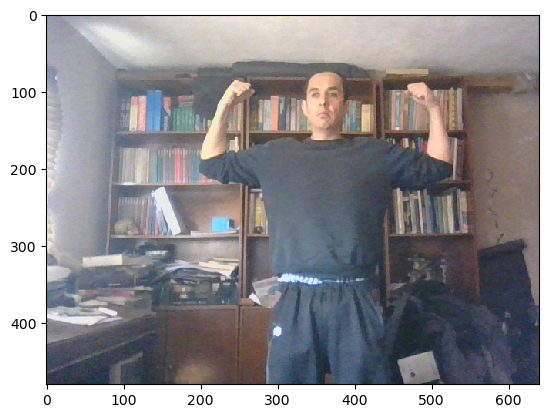

In [8]:
rospy.sleep(5)
data = rospy.wait_for_message("/usb_cam/image_raw",Image,timeout=5) ### FOR DEBUGGING: WHEN USING ROBOT PLEASE CHANGE THIS TOPIC ACCORDINGLY
cv2_img = bridge.imgmsg_to_cv2(data)#, "bgr8")
plt.imshow(cv2_img)
image=np.copy(cv2_img)


In [9]:
frame=image
inHeight = frame.shape[0]
inWidth = frame.shape[1]


# Prepare the frame to be fed to the network
inpBlob = cv2.dnn.blobFromImage(frame, 1.0 / 255, (inWidth, inHeight), (0, 0, 0), swapRB=False, crop=False)

# Set the prepared object as the input blob of the network
net.setInput(inpBlob)

output = net.forward()

In [10]:
output.shape

(1, 78, 60, 80)

In [15]:
H = output.shape[2]
W = output.shape[3]
threshold=0.5
# Empty list to store the detected keypoints
points = []
for i in range(25):
    # confidence map of corresponding body's part.
    probMap = output[0, i, :, :]
    

    # Find global maxima of the probMap.
    _, prob,_, point = cv2.minMaxLoc(probMap)
    print (point, prob)

    # Scale the point to fit on the original image
    x = (inWidth * point[0]) / W
    y = (inHeight * point[1]) / H

    if prob > threshold :
        cv2.circle(frame, (int(x), int(y)), 1, (0, 255, 255), thickness=-1, lineType=cv2.FILLED)
        cv2.putText(frame, "{}".format(i), (int(x), int(y)), cv2.FONT_HERSHEY_SIMPLEX, 0.51, (0, 0, 255), 1, lineType=cv2.LINE_AA)

        # Add the point to the list if the probability is greater than the threshold
        points.append((int(x), int(y)))
    else :
        points.append(None)

cv2.imshow("Output-Keypoints",frame)
cv2.waitKey(0)
cv2.destroyAllWindows()


(45, 14) 0.7764601111412048
(45, 22) 0.5477964282035828
(37, 22) 0.38596421480178833
(26, 24) 0.41277411580085754
(29, 14) 0.1926087737083435
(52, 22) 0.4050917625427246
(62, 25) 0.19177745282649994
(66, 27) 0.029250821098685265
(45, 43) 0.13324923813343048
(40, 43) 0.1194407045841217
(21, 43) 0.0030720033682882786
(58, 41) 0.002883616369217634
(49, 43) 0.13680802285671234
(28, 21) 0.0027906352188438177
(58, 42) 0.002412613946944475
(43, 13) 0.7671812176704407
(46, 12) 0.8099166750907898
(42, 14) 0.6915377378463745
(48, 14) 0.7517814636230469
(48, 14) 0.016521891579031944
(37, 23) 0.009758822619915009
(48, 13) 0.0200254675000906
(43, 23) 0.026317963376641273
(43, 21) 0.007437057327479124
(42, 12) 0.04782542213797569


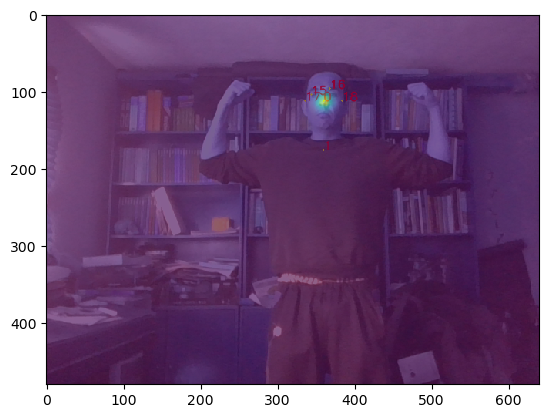

In [18]:
i = 0
probMap = output[0, i, :, :]
probMap = cv2.resize(probMap, (inWidth, inHeight))



plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

plt.imshow(probMap, alpha=0.6)

In [19]:
points

[(144, 208),
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 (136, 192),
 (176, 192),
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [20]:
def point_2D_3D(points_data, px_y, px_x):
    ##px pixels /2D world  P1 3D world
    ## rgbd pOINTCLOUD2 numpify
    P = np.asarray((points_data[px_y, px_x]['x'], points_data[px_y, px_x]['y'], points_data[px_y, px_x]['z']))
    return P


In [ ]:
def probmap_to_3d_mean(points_data,)
xyz=[]
if len (npmask)>0.1:
    for a in npmask:
        ix,iy=a[0],a[1]
        aux=(np.asarray((points_data['x'][boundRect[1]+ix,boundRect[0]+iy],points_data['y'][boundRect[1]+ix,boundRect[0]+iy],points_data['z'][boundRect[1]+ix,boundRect[0]+iy])))
        #print (aux)
        if np.isnan(aux[0]) or np.isnan(aux[1]) or np.isnan(aux[2]):
                'reject point'
        else:
            xyz.append(aux)

xyz=np.asarray(xyz)
#print (xyz)
cent=xyz.mean(axis=0)


In [25]:
probMap
npmask= np.where(probMap<0.1,0,probMap)

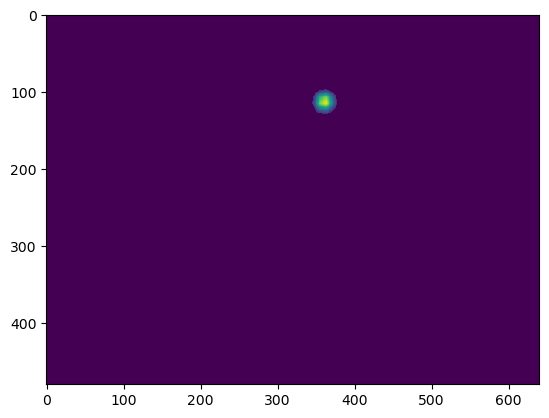

In [26]:
plt.imshow(npmask)

In [9]:
DeepFace.extract_faces(image)

ValueError: Face could not be detected. Please confirm that the picture is a face photo or consider to set enforce_detection param to False.

In [6]:
from face_recog.msg import *

In [7]:
from face_recog.srv import *

In [8]:
def train_face(image, name):
    req=RecognizeFaceRequest()
    strings=Strings()
    string_msg= String()
    string_msg.data=name
    req.Ids.ids.append(string_msg)

    img_msg=bridge.cv2_to_imgmsg(image)
    req.in_.image_msgs.append(img_msg)
    res=train_new_face(req)
    return res.Ids.ids[0].data.split(' ')[0] == 'trained'

In [9]:
### LAUNCH SERVICE OR WAIT FOREVER (VALOR MORGULIS)

rospy.wait_for_service('recognize_face')

In [10]:
### LAUNCH SERVICE OR WAIT FOREVER (VALOR MORGULIS)
rospy.wait_for_service('new_face')
rospy.wait_for_service('analyze_face')



KeyboardInterrupt: 

In [11]:
train_new_face = rospy.ServiceProxy('new_face', RecognizeFace)    
recognize = rospy.ServiceProxy('recognize_face', RecognizeFace)    
#analyze = rospy.ServiceProxy('analyze_face', RecognizeFace)    

In [12]:
req=RecognizeFaceRequest()

strings=Strings()
string_msg= String()
string_msg.data='any'
req.Ids.ids.append(string_msg)

img_msg=bridge.cv2_to_imgmsg(cv2_img)
req.in_.image_msgs.append(img_msg)
res=recognize(req)
#res = analyze(req)
res

Ds: 
  data: [0.5546572208404541]
Angs: 
  data: [133.0, 218.0, 288.0, 133.0, -0.288587361574173]
Ids: 
  ids: 
    - 
      data: "Jack"
    - 
      data: "Jack"

In [13]:
string_msg.data='Jack'
res=train_new_face(req)  ### FOR TRAINING! IF NAME IS REPETAED WILL CRASH
res

Ds: 
  data: [0.0, 0.0]
Angs: 
  data: [1.0, 1.0]
Ids: 
  ids: 
    - 
      data: "trained new id_Jack"

In [4]:
from smach_utils2 import *

the rosdep view is empty: call 'sudo rosdep init' and 'rosdep update'
[ WARN] [1678138288.862634149]: Link hand_l_finger_vacuum_frame has visual geometry but no collision geometry. Collision geometry will be left empty. Fix your URDF file by explicitly specifying collision geometry.
[ WARN] [1678138288.885788873]: Link head_l_stereo_camera_link has visual geometry but no collision geometry. Collision geometry will be left empty. Fix your URDF file by explicitly specifying collision geometry.
[ WARN] [1678138288.886215567]: Link head_r_stereo_camera_link has visual geometry but no collision geometry. Collision geometry will be left empty. Fix your URDF file by explicitly specifying collision geometry.
[ WARN] [1678138288.887746946]: Group state 'neutral' doesn't specify all group joints in group 'arm'. wrist_ft_sensor_frame_joint is missing.
[ WARN] [1678138288.888556359]: Group state 'go' doesn't specify all group joints in group 'arm'. wrist_ft_sensor_frame_joint is missing.
[ WARN] [

In [52]:
points=rgbd.get_points()

In [76]:
def bbox_3d_mean(points,bbox):
    
    xyz=[]
    bbox[0]
    for i in np.arange((int)(bbox[0]),(int)(bbox[0])+(int)(bbox[2])):
        for j in np.arange((int)(bbox[1]),(int)(bbox[1])+(int)(bbox[3])):
            aa=np.asarray(points[['x','y','z']][i,j])
            if np.isnan(np.asarray((aa['x'],aa['y'],aa['z']))).sum() ==0:                   
                xyz.append(np.asarray((aa['x'],aa['y'],aa['z'])) )
    return np.asarray(xyz).mean(axis=0)

In [73]:
def bbox_3d_mean(points,bbox):
    
    xyz=[]

    for i in np.arange((int)(21.0),(int)(21.0)+(int)(187.0)):
        for j in np.arange((int)(178.0),(int)(178.0)+(int)(344.0)):
            aa=np.asarray(points[['x','y','z']][i,j])
            if np.isnan(np.asarray((aa['x'],aa['y'],aa['z']))).sum() ==0:                   
                xyz.append(np.asarray((aa['x'],aa['y'],aa['z'])) )

In [70]:
x,y,z=xyzz.mean(axis=0)
x,y,z

(0.087547965, -0.38353324, 1.6179111)

In [74]:
bbox=(21,178,187,344)

In [77]:
trans=bbox_3d_mean(points,bbox)
trans

array([ 0.08754797, -0.38353324,  1.6179111 ], dtype=float32)

In [71]:
trans=xyzz.mean(axis=0)
trans[2]+=600
trans

array([ 8.7547965e-02, -3.8353324e-01,  6.0161792e+02], dtype=float32)

In [72]:
points

array([[(-1.1957033 , -0.8963096 , 2.074733  , 1.6396335e-38),
        (-1.1919606 , -0.89630944, 2.0747325 , 1.6488172e-38),
        (-1.1882179 , -0.8963092 , 2.074732  , 1.6488172e-38), ...,
        ( 0.68943644, -0.52006304, 1.2038162 , 2.3509886e-38),
        ( 0.69160765, -0.5200629 , 1.2038158 , 2.3509886e-38),
        ( 0.693779  , -0.5200628 , 1.2038156 , 2.3509886e-38)],
       [(-1.1925887 , -0.8902423 , 2.0693288 , 1.6396335e-38),
        (-1.1888558 , -0.89024204, 2.0693283 , 1.6304141e-38),
        (-1.1851228 , -0.89024186, 2.0693278 , 1.6304141e-38), ...,
        ( 0.68764085, -0.51654285, 1.200681  , 2.3509886e-38),
        ( 0.68980646, -0.5165427 , 1.2006806 , 2.3509886e-38),
        ( 0.69197214, -0.51654255, 1.2006804 , 2.3509886e-38)],
       [(-1.1894903 , -0.8842064 , 2.0639527 , 1.6396335e-38),
        (-1.1857669 , -0.8842061 , 2.063952  , 1.6304141e-38),
        (-1.1820438 , -0.88420606, 2.0639517 , 1.6396337e-38), ...,
        ( 0.6858546 , -0.51304084, 1.1

In [56]:
aux=(points[['x','y','z']][-20,410])
#np.isnan(aux)
aa=np.asarray(aux)
np.isnan(np.asarray((aa['x'],aa['y'],aa['z']))).sum()==0

True

[ WARN] [1678139555.330875865, 238.665000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 238.665000 according to authority /pose_integrator
[ WARN] [1678139555.330932233, 238.665000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 238.665000 according to authority /pose_integrator
[ WARN] [1678139555.330955675, 238.665000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 238.665000 according to authority /pose_integrator
[ WARN] [1678139555.330984275, 238.665000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 238.665000 according to authority /pose_integrator
[ WARN] [1678139555.331330629, 238.665000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 238.665000 according to authority unknown_publisher


In [25]:
21.0, 178.0, 187.0, 344.0
for i 

aux=(points[['x','y','z']][-20,410])

TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

[ WARN] [1678138725.923177069, 101.322000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 101.337000 according to authority /pose_integrator
[ WARN] [1678138725.923239199, 101.322000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 101.337000 according to authority /pose_integrator
[ WARN] [1678138725.923264339, 101.322000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 101.337000 according to authority /pose_integrator
[ WARN] [1678138725.923285781, 101.322000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 101.337000 according to authority /pose_integrator
[ WARN] [1678138725.924841789, 101.322000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 101.337000 according to authority unknown_publisher
[ WARN] [1678138728.519904910, 101.832000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame o

[ WARN] [1678138755.688241399, 106.932000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 106.980000 according to authority /pose_integrator
[ WARN] [1678138755.688315633, 106.932000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 106.980000 according to authority /pose_integrator
[ WARN] [1678138755.688350428, 106.932000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 106.980000 according to authority /pose_integrator
[ WARN] [1678138755.688372684, 106.932000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 106.980000 according to authority /pose_integrator
[ WARN] [1678138755.702630875, 106.980000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 106.980000 according to authority unknown_publisher
[ WARN] [1678138765.484692700, 108.840000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame o

[ WARN] [1678138784.466065698, 111.972000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 111.972000 according to authority /pose_integrator
[ WARN] [1678138784.466114250, 111.972000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 111.972000 according to authority /pose_integrator
[ WARN] [1678138784.466137746, 111.972000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 111.972000 according to authority /pose_integrator
[ WARN] [1678138784.466158062, 111.972000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 111.972000 according to authority /pose_integrator
[ WARN] [1678138784.479874515, 111.972000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 111.972000 according to authority unknown_publisher
[ WARN] [1678138789.540755639, 112.863000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame o

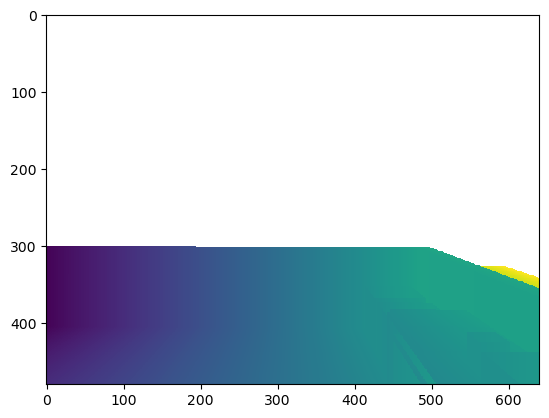

[ WARN] [1678138580.361903151, 73.422000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 73.422000 according to authority unknown_publisher
[ WARN] [1678138580.362381208, 73.422000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 73.422000 according to authority /pose_integrator
[ WARN] [1678138580.362420487, 73.422000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 73.422000 according to authority /pose_integrator
[ WARN] [1678138580.362444032, 73.422000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 73.422000 according to authority /pose_integrator
[ WARN] [1678138580.362465490, 73.422000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 73.422000 according to authority /pose_integrator
[ WARN] [1678138594.469306441, 76.191000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time

[ WARN] [1678138625.711999828, 81.945000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 81.987000 according to authority /pose_integrator
[ WARN] [1678138625.712048044, 81.945000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 81.987000 according to authority /pose_integrator
[ WARN] [1678138625.712072134, 81.945000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 81.987000 according to authority /pose_integrator
[ WARN] [1678138625.712096684, 81.945000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 81.987000 according to authority /pose_integrator
[ WARN] [1678138625.712669528, 81.987000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 81.987000 according to authority unknown_publisher
[ WARN] [1678138626.231673162, 82.089000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time

[ WARN] [1678138665.138544037, 90.231000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 90.237000 according to authority unknown_publisher
[ WARN] [1678138665.140173394, 90.231000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 90.237000 according to authority /pose_integrator
[ WARN] [1678138665.140278858, 90.231000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 90.237000 according to authority /pose_integrator
[ WARN] [1678138665.140318272, 90.231000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 90.237000 according to authority /pose_integrator
[ WARN] [1678138665.140354426, 90.231000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 90.237000 according to authority /pose_integrator
[ WARN] [1678138666.645970006, 90.348000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time

In [22]:
plt.imshow (points['x'])

In [3]:
data=(21.0, 178.0, 187.0, 344.0)
data

(21.0, 178.0, 187.0, 344.0)

In [ ]:
try:
    res=DeepFace.extract_faces(image )
    print ('face found')
    dfs = DeepFace.find(image,path_for_faces)
    print('id',dfs[0]['identity'].iloc[0].split('/')[-2])
except(ValueError): 
    print('No Face')

In [ ]:
#### DISPLAY IMAGE?#############3
#obj=res
pt1 = res[0]['facial_area']['x'],res[0]['facial_area']['y'] 
pt2=  res[0]['facial_area']['x']+res[0]['facial_area']['w'] , res[0]['facial_area']['y']+ res[0]['facial_area']['h']
img=cv2.rectangle(image, pt1,pt2, (0, 0, 255), 2)
img = cv2.putText(img, dfs[0]['identity'].iloc[0].split('/')[-2], pt1, cv2.FONT_HERSHEY_SIMPLEX, 
                   1, (255, 0, 0), 2, cv2.LINE_AA)
   


In [ ]:
plt.imshow(cv2_img)

In [ ]:
plt.imshow(img)

In [ ]:
dfs = DeepFace.find(image,path_for_faces)
dfs[0]['identity'].iloc[0].split('/')[-2]

In [ ]:

dfs = DeepFace.find(image,path_for_faces)

In [13]:
from deepface import DeepFace

2023-03-06 16:38:08.881568: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-06 16:38:10.140527: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/oscar/.local/lib/python3.8/site-packages/cv2/../../lib64:/usr/local/cuda-11.5/lib64:/home/oscar/catkin_extras/devel/lib:/opt/ros/noetic/lib:/opt/ros/noetic/lib/x86_64-linux-gnu
2023-03-06 16:38:10.140934: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared obje

ValueError: Face could not be detected. Please confirm that the picture is a face photo or consider to set enforce_detection param to False.

In [43]:
objs = DeepFace.analyze(image, 
        actions = ['age', 'gender', 'race', 'emotion']
)

ResourceExhaustedError: {{function_node __wrapped__Mul_device_/job:localhost/replica:0/task:0/device:GPU:0}} failed to allocate memory [Op:Mul]

In [22]:
objs

NameError: name 'objs' is not defined

In [20]:
objs[0]['region']

NameError: name 'objs' is not defined

In [25]:
objs[0]['dominant_gender'],objs[0]['dominant_race'],objs[0]['dominant_emotion'],objs[0]['age']

('Man', 'middle eastern', 'sad', 42)

In [26]:
for st in (objs[0]['dominant_gender'],objs[0]['dominant_race'],objs[0]['dominant_emotion'],objs[0]['age']):
    print (st)

Man
middle eastern
sad
42


In [42]:
objs[0]['age']

NameError: name 'objs' is not defined

In [ ]:
from face_recog.msg import *

In [ ]:
from face_recog.srv import *

In [ ]:
def train_face(image, name):
    req=RecognizeFaceRequest()
    strings=Strings()
    string_msg= String()
    string_msg.data=name
    req.Ids.ids.append(string_msg)

    img_msg=bridge.cv2_to_imgmsg(image)
    req.in_.image_msgs.append(img_msg)
    res=train_new_face(req)
    return res.Ids.ids[0].data.split(' ')[0] == 'trained'

In [ ]:
### LAUNCH SERVICE OR WAIT FOREVER (VALOR MORGULIS)

rospy.wait_for_service('recognize_face')

In [ ]:
### LAUNCH SERVICE OR WAIT FOREVER (VALOR MORGULIS)
rospy.wait_for_service('new_face')


In [ ]:
train_new_face = rospy.ServiceProxy('new_face', RecognizeFace)    
recognize = rospy.ServiceProxy('recognize_face', RecognizeFace)    

In [ ]:
req=RecognizeFaceRequest()

strings=Strings()
string_msg= String()
string_msg.data='any'
req.Ids.ids.append(string_msg)

img_msg=bridge.cv2_to_imgmsg(cv2_img)
req.in_.image_msgs.append(img_msg)
res=recognize(req)
res

In [ ]:
plt.imshow(cv2_img)

In [15]:
req=RecognizeFaceRequest()

strings=Strings()
string_msg= String()
string_msg.data='Jack'
req.Ids.ids.append(string_msg)

img_msg=bridge.cv2_to_imgmsg(image)
req.in_.image_msgs.append(img_msg)




In [38]:
res=train_new_face(req)  ### FOR TRAINING! IF NAME IS REPETAED WILL CRASH
res

Ds: 
  data: [0.0, 0.0]
Angs: 
  data: [1.0, 1.0]
Ids: 
  ids: 
    - 
      data: "trained new id_Jack"

In [28]:
import face_recognition

In [33]:
face_recognition.face_locations(cv2_img)

RuntimeError: Unsupported image type, must be 8bit gray or RGB image.

In [ ]:
###################Using Navigation to get to a Distance from this face$$

In [ ]:
listener = tf.TransformListener()
broadcaster = tf.TransformBroadcaster()
pub_goal= rospy.Publisher('/navigate/goal', NavigateActionGoal, queue_size=1)

In [ ]:
d=res.Ds.data[0]
D_to_person=0.15
pose=np.zeros(3)
pose[2]+=d - D_to_person
quat=np.zeros(4)
quat[-1]=1
    

broadcaster.sendTransform(pose, quat,rospy.Time.now(), 'face','head_rgbd_sensor_link')
for i in range (10):
    try:
        goal_pose, quat=listener.lookupTransform( 'map','face', rospy.Time(0))
        print('yes tf')
        break
    except:
        print  ('No tf')
        rospy.sleep(0.2)

In [ ]:

goal_pose
goal= NavigateActionGoal()
goal.goal.x=goal_pose[0]
goal.goal.y=goal_pose[1]

goal.goal.timeout= 10
nav_res= NavigateActionResult()
pub_goal.publish(goal)

In [ ]:
image

In [1]:
from smach_utils2 import *

the rosdep view is empty: call 'sudo rosdep init' and 'rosdep update'
[ WARN] [1679093105.525509994]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2328.726000 according to authority /pose_integrator
[ WARN] [1679093116.636585080, 2329.298000000]: Link hand_l_finger_vacuum_frame has visual geometry but no collision geometry. Collision geometry will be left empty. Fix your URDF file by explicitly specifying collision geometry.
[ WARN] [1679093116.663510289, 2329.298000000]: Link head_l_stereo_camera_link has visual geometry but no collision geometry. Collision geometry will be left empty. Fix your URDF file by explicitly specifying collision geometry.
[ WARN] [1679093116.663660844, 2329.298000000]: Link head_r_stereo_camera_link has visual geometry but no collision geometry. Collision geometry will be left empty. Fix your URDF file by explicitly specifying collision geometry.
[ WARN] [1679093116.665933739, 2329.298000000]: Group state 'neutral' doesn't s

In [ ]:
res= speech_recog_server()

In [ ]:
res.data

In [ ]:
res2=train_face(image,res.data)


In [ ]:
res2.Ids.ids[0].data.split(' ')[0] == 'trained'

In [ ]:
train_face(image,res.data)

In [ ]:
req

In [ ]:

from smach_utils2 import *
from rospkg import RosPack

In [16]:
rp = RosPack()
path = rp.get_path('config_files')

In [17]:
path

'/home/oscar/catkin_extras/src/navigation_pumas/config_files'

In [45]:
from rospkg import RosPack

rp = RosPack()
path_for_faces = rp.get_path('config_files')+'/faces_for_recognition'


In [46]:
path_for_faces

'/home/oscar/catkin_extras/src/navigation_pumas/config_files/faces_for_recognition'

In [43]:
path_for_faces = rp.get_path('config_files')

In [47]:
for person in os.listdir(path_for_faces):
    print (person)

Scarlet
Jack
Curtuois


In [21]:
import os
os.listdir(path_for_faces)[1]

'Jack'

In [5]:
omni_base.move_base(1,1,np.pi,1)

In [9]:
print (res)

NameError: name 'res' is not defined

[ WARN] [1679091710.429942345, 2369.969000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2370.004000 according to authority /pose_integrator
[ WARN] [1679091710.430037367, 2369.969000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2370.004000 according to authority /pose_integrator
[ WARN] [1679091710.430066156, 2369.969000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2370.004000 according to authority /pose_integrator
[ WARN] [1679091710.430088269, 2369.969000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2370.004000 according to authority /pose_integrator
[ WARN] [1679091710.430377040, 2369.969000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2370.004000 according to authority unknown_publisher
[ WARN] [1679091724.170379747, 2370.680000000]: TF_REPEATED_DATA ignoring data with redundant timestamp 

[ WARN] [1679091744.114938977, 2371.857000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2371.906000 according to authority /pose_integrator
[ WARN] [1679091744.115102497, 2371.857000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2371.906000 according to authority /pose_integrator
[ WARN] [1679091744.115169677, 2371.857000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2371.906000 according to authority /pose_integrator
[ WARN] [1679091744.115216200, 2371.857000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2371.906000 according to authority /pose_integrator
[ WARN] [1679091744.120903328, 2371.857000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2371.906000 according to authority unknown_publisher
[ WARN] [1679091747.970257641, 2372.176000000]: TF_REPEATED_DATA ignoring data with redundant timestamp 

In [2]:
robot, robotquat = tf_man.getTF('base_link')
new_yaw = (tf.transformations.euler_from_quaternion(robotquat)[2]+np.pi)
print(new_yaw)
# go to living room an do a 180
res = omni_base.move_base(robot[0], robot[1], new_yaw)

3.132495382940123
header: 
  seq: 0
  stamp: 
    secs: 0
    nsecs:         0
  frame_id: ''
goal_id: 
  stamp: 
    secs: 0
    nsecs:         0
  id: ''
goal: 
  x: 0.0008538187339530712
  y: -0.001003958465405958
  yaw: 3.132495382940123
  timeout: 10
  known_location: "None"


[ WARN] [1679093195.366633228, 2332.837000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2332.896000 according to authority /pose_integrator
[ WARN] [1679093195.366680922, 2332.837000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2332.896000 according to authority /pose_integrator
[ WARN] [1679093195.366705075, 2332.837000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2332.896000 according to authority /pose_integrator
[ WARN] [1679093195.366726728, 2332.837000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2332.896000 according to authority /pose_integrator
[ WARN] [1679093195.367154750, 2332.837000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2332.896000 according to authority unknown_publisher
[ WARN] [1679093264.326915623, 2335.343000000]: TF_REPEATED_DATA ignoring data with redundant timestamp 

[ WARN] [1679093465.480060561, 2342.968000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2342.991000 according to authority unknown_publisher
[ WARN] [1679093465.480128736, 2342.968000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2342.991000 according to authority /pose_integrator
[ WARN] [1679093465.480178843, 2342.968000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2342.991000 according to authority /pose_integrator
[ WARN] [1679093465.480233021, 2342.968000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2342.991000 according to authority /pose_integrator
[ WARN] [1679093465.480270723, 2342.968000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2342.991000 according to authority /pose_integrator
[ WARN] [1679093476.301774001, 2343.597000000]: TF_REPEATED_DATA ignoring data with redundant timestamp 